In [1]:
import pandas as pd
import numpy as np
import random
import copy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patches
import brewer2mpl
from matplotlib import rcParams
import pylab

import folium # for map visualization, and this is a new package needed to be installed from the anaconda.
from folium import plugins
from folium.plugins import HeatMap

from sklearn import datasets, linear_model, neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors.kde import KernelDensity
from sklearn.svm import SVR 
from sklearn.model_selection import train_test_split
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

import itertools

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
"""Questions to be asked: 

1. sqft_basement cannot be logged but way to skewer, will this be ok in the SVR?
2. Correlations between the independent variables influence on SVR?
3. R2 is negative?
4. Poly runs too long?
5. Kernel and size: everytime will it be different?
6. Other validation besides RSME? GridSearchCV?

"""

In [ ]:
""" Some tutorials:
Data:
https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

Map Folium:
http://www.kobakhit.com/beginner/2016/03/06/visualizing-indego-bike-geoson-data-in-python-using-folium.html
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

Outliers: 
http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm

"""

In [2]:
"""Read in original data and deal with "date":

"""

# Read in data, and cleaned the 'date' as a date type.
df=pd.read_csv('kc_house_data.csv', parse_dates = ['date'])
#df.head(7)



In [3]:
""" First attempt to clean the data:

"""

# Taking out un-needed variables
df = df.drop(df.columns[[0, 11, 15, 16, 19, 20]], axis=1)
#df.head(7)

# Add year and month: 
df['yr'] = df['date'].dt.year
df['month'] = df['date'].dt.month
#df.head(7)

In [4]:
""" Index months: from 1 to 13, for May 2014 to May 2015 respectively.

"""

# If year is 2015, then new month equals to old month plus 12, then replace NaNs with old months:
df["month_temp"] = df["month"][df["yr"] == 2015] + 12
df["month_temp"].fillna(df["month"], inplace = True)

# Adjust the indexes for months, rescale from 1 to 13:
df["month_all"] = df["month_temp"] - 4

# Only keep the month_all column:
df.drop(['month_temp'], axis=1, inplace = True)

df.head(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,lat,long,yr,month,month_all
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,1180,0,1955,47.5112,-122.257,2014,10,6.0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,2170,400,1951,47.7210,-122.319,2014,12,8.0
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,770,0,1933,47.7379,-122.233,2015,2,10.0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,1050,910,1965,47.5208,-122.393,2014,12,8.0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,1680,0,1987,47.6168,-122.045,2015,2,10.0
5,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,3890,1530,2001,47.6561,-122.005,2014,5,1.0
6,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,1715,0,1995,47.3097,-122.327,2014,6,2.0


In [ ]:
"""Descriptive Figures - 1:

"""
# Step 1: Plot histograms for all the variables
fig = plt.figure(figsize=(20, 16))
for ele in range(1,13):
    ax = fig.add_subplot(4, 3, ele)
    ax.hist(df[df.columns[ele]])
    ax.set_title(df.columns[ele])

pylab.savefig('Data Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that bedrooms, bathrooms, floors and yr_built cannot be treated as continous variables. 

# Step 2: run the KS-tests for each of the variables, with a normal distribution of the variable mean and variable stds.
lst_continuous = ["price", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]

for ele in lst_continuous:
    mean = np.mean(df[ele])
    std = np.std(df[ele])
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))
# Noted that all the null hypothesis are rejected. I need to transform. 

# Step 3: log all the elements in lst_continuous, and run the KS-tests as the same as the above, and graph the logged histograms.
# Spectial note: from the previous cell, I know that "sqt_basement" has value 0, which will cause problems with log, so I exclude it here.
lst_log = ["price", "sqft_living", "sqft_lot", "sqft_above"]

fig = plt.figure(figsize=(20, 16))
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.hist(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele))

pylab.savefig('Logged Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that now, the logged histograms look great, so I need to check the normality.

# Step 4: repeat step 2 with the logged data from step 3.
for ele in lst_log:
    mean = np.mean(np.log(df[ele]))
    std = np.std(np.log(df[ele]))
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for Logged {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))

fig = plt.figure(figsize=(20, 16))    
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.boxplot(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele))

pylab.savefig('Logged Data Boxplot', dpi = 80, figsize = (20,6))
plt.show()

In [ ]:
""" Based on the above, I want to transform some of the variables into logged data,
since normality are usually preferred/required when performing analysis, and I want to get this done before dig into the real analysis.

"""

In [5]:
"""Make Logged columns and creat new columns:

"""
df["logged_price"] =  np.log(df["price"])
df["logged_living"] = np.log(df["sqft_living"])
df["logged_lot"] = np.log(df["sqft_lot"])
df["logged_above"] = np.log(df["sqft_above"])
df["Grade"] = df["waterfront"] + df["view"] + df["condition"]

print(df.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'yr', 'month', 'month_all',
       'logged_price', 'logged_living', 'logged_lot', 'logged_above', 'Grade'],
      dtype='object')


In [ ]:
"""Descriptive Figures - 1: Logged data

"""

lst_log = ["price", "sqft_living", "sqft_lot", "sqft_above"]

fig = plt.figure(figsize=(20, 16))
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.hist(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele))

pylab.savefig('Logged Histograms', dpi = 80, figsize = (20,6))
plt.show()

# Noted that now, the logged histograms look great, so I need to check the normality.

# Step 4: repeat step 2 with the logged data from step 3.
for ele in lst_log:
    mean = np.mean(np.log(df[ele]))
    std = np.std(np.log(df[ele]))
    
    df_normal = np.random.normal(loc=mean, scale=std, size=1000)
    
    results = stats.ks_2samp(df[ele], df_normal)
    print("Results for Logged {}: Statistic = {}, p-value = {}\n".format(ele, results.statistic, results.pvalue))

fig = plt.figure(figsize=(20, 16))    
for n, ele in zip(range(1,5), lst_log):
    ax = fig.add_subplot(2, 2, n)
    ax.boxplot(np.log(df[ele]))
    ax.set_title("Logged {}".format(ele))

pylab.savefig('Logged Data Boxplot', dpi = 80, figsize = (20,6))
plt.show()

In [7]:
"""Missing value, data types.

"""
# Check the missing value
print(df.isnull().any())
print()

# Check the data types for each column
print(df.dtypes)

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
lat              False
long             False
yr               False
month            False
logged_price     False
logged_living    False
logged_lot       False
logged_above     False
Grade            False
month_all        False
dtype: bool

date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
lat                     float64
long      

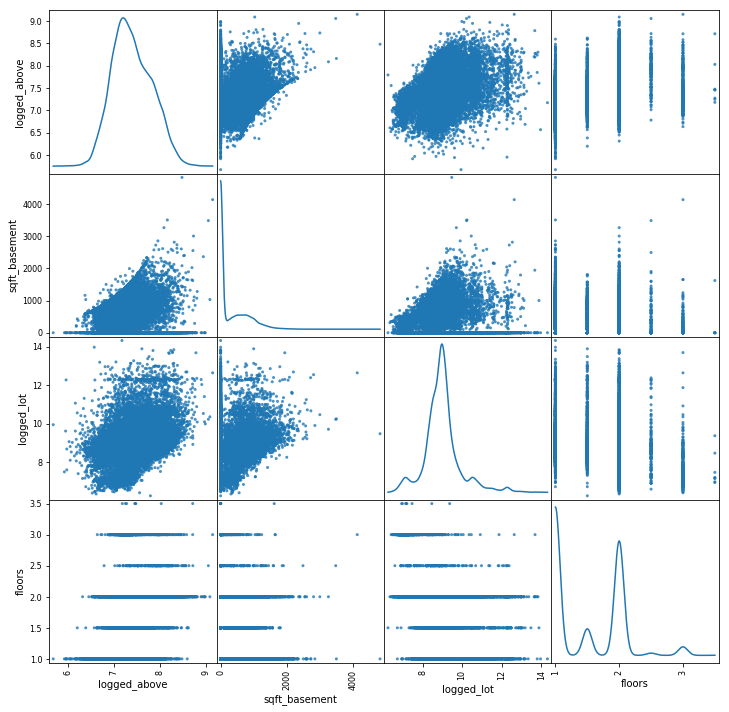

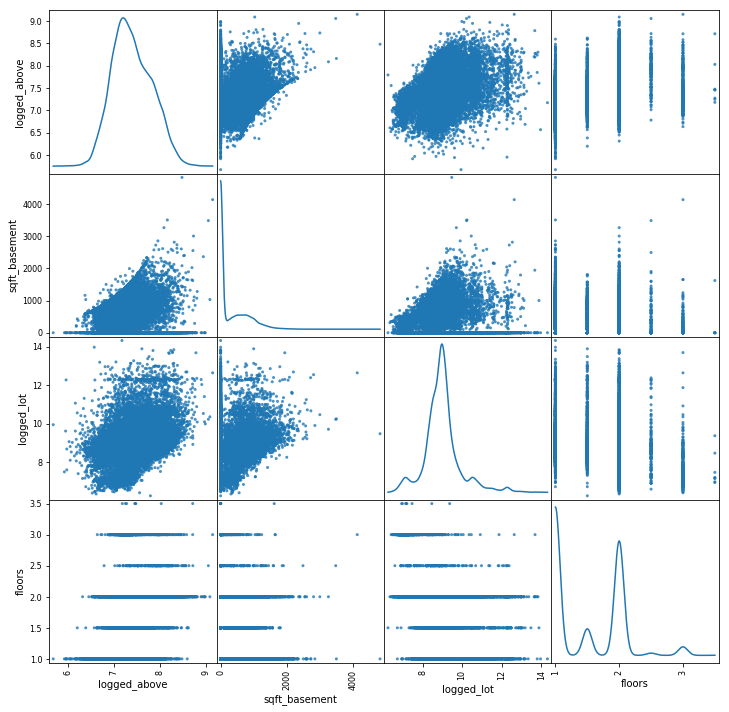

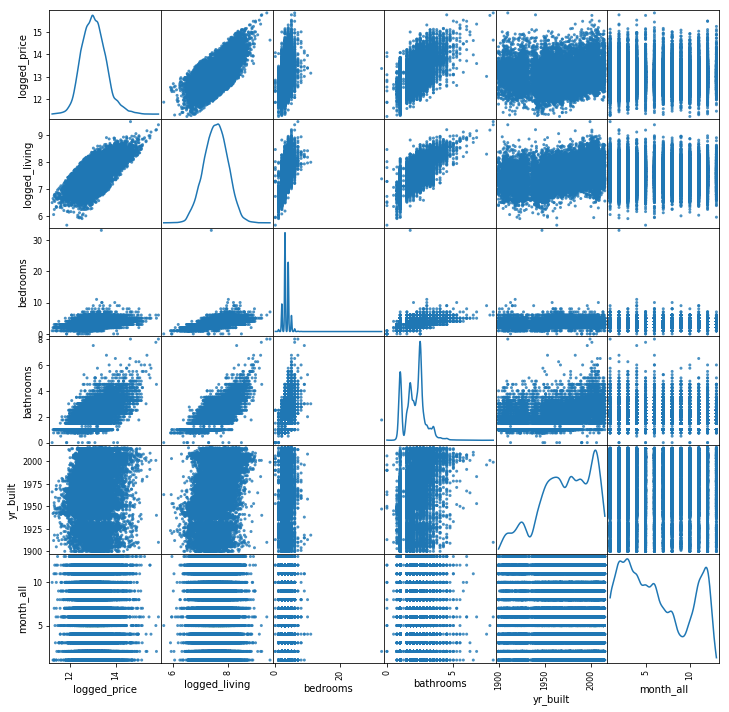

In [15]:
"""Descriptive Figures - 2: Scatter Matrix

Main variables + dependent variable

"""
smaller_frame=df[['logged_price', "logged_living", "bedrooms", 
           "bathrooms", "yr_built", "month_all"]]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

pylab.savefig('Scatter Matrix_main', dpi = 80, figsize = (20,6))
plt.show()    

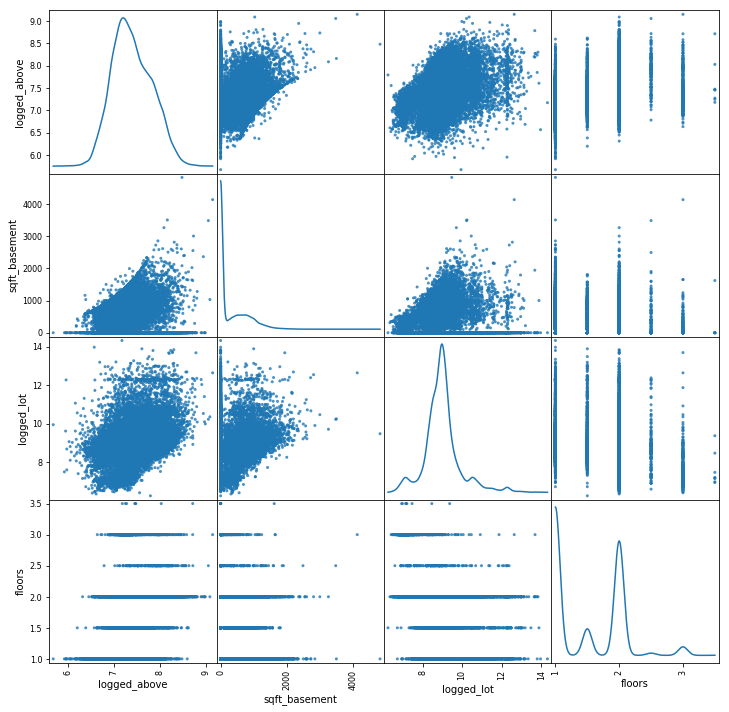

In [16]:
"""Descriptive Figures - 3: Scatter Matrix

"""
smaller_frame=df[["logged_above", "sqft_basement", "logged_lot", "floors"]]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

pylab.savefig('Scatter Matrix_other', dpi = 80, figsize = (20,6))
plt.show()

In [ ]:
""" From above, I see I need to detect and remove outliers.  
However, given some of the variables are not likely to be normally distributed, 
that being said that the "outliers" could be just results from the non-normality.
Thus, I need a closer look into them to determine whether to remove the data point. 
"""

In [19]:
"""Outlier Detection - 1: Descriptive Stats

"""

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,...,lat,long,yr,month,logged_price,logged_living,logged_lot,logged_above,Grade,month_all
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,1788.390691,...,47.560053,-122.213896,2014.322954,6.574423,13.047817,7.550335,8.989956,7.394877,3.651275,6.449868
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,828.090978,...,0.138564,0.140828,0.467616,3.115308,0.526685,0.424807,0.902425,0.427631,1.057934,3.720034
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,290.000000,...,47.155900,-122.519000,2014.000000,1.000000,11.225243,5.669881,6.253829,5.669881,1.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,...,47.471000,-122.328000,2014.000000,4.000000,12.682152,7.263330,8.525161,7.081709,3.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,1560.000000,...,47.571800,-122.230000,2014.000000,6.000000,13.017003,7.554859,8.938269,7.352441,3.000000,6.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,2210.000000,...,47.678000,-122.125000,2015.000000,9.000000,13.377006,7.843849,9.276877,7.700748,4.000000,10.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,...,47.777600,-121.315000,2015.000000,12.000000,15.856731,9.513404,14.317109,9.149528,10.000000,13.000000


In [ ]:
""" From above description: I want to take a closer look at the large numbers of bedrooms and large numbers of bathrooms.

"""

In [24]:
""" Outlier Detection - 2: Close-up

"""

print(df[df["bathrooms"]==8])
print()
print(df[df['bedrooms']>7])

            date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7252  2014-10-13  7700000.0         6        8.0        12050     27600   
12777 2014-05-05  2280000.0         7        8.0        13540    307752   

       floors  waterfront  view  condition    ...          lat     long    yr  \
7252      2.5           0     3          4    ...      47.6298 -122.323  2014   
12777     3.0           0     4          3    ...      47.6675 -121.986  2014   

       month  logged_price  logged_living  logged_lot  logged_above  Grade  \
7252      10     15.856731       9.396820   10.225571      9.056023      7   
12777      5     14.639686       9.513404   12.637050      9.149528      7   

       month_all  
7252         6.0  
12777        1.0  

[2 rows x 23 columns]

            date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
1660  2014-12-04   490000.0         8       5.00         2800      2580   
4035  2014-10-07  2150000.0         8       6.00         4340   

In [ ]:
""" From above, I think the 8 bathrooms might be possible given both of the houses have more than 2 floors and nearly 8 bedrooms.
However, I decide to remove outliers from "bedrooms" since some of the data does not make sense.
Despite the obvious error of 33 bedrooms, it is less likely that one has 11 bedrooms with only 3 bathrooms in a 2-floor house.  

"""

In [6]:
"""Outliers detection - 3: Function 

Median absolute deviation (MAD)
Noted that this requires normality, since otherwise the appearances of "outliers" might only from the non-normality of the data.

Normally distributed variables: logged_price, logged_living, logged_lot, logged_above, bedrooms
"""

# Step 2: Median absolute deviation (MAD) to detect outliers and then give these outliers a closer look.


# Define a function for the detection:
def outliers_mad(ys):
    threshold = 3.5

    median_y = np.median(np.array(ys))
    MAD_y = np.median(np.abs(np.array(ys - median_y)))
    df['MAD'] = 0.6745 * (ys - median_y) / MAD_y 
    print(df.columns)
    

# Call the function:
#outliers_mad(df["logged_lot"])
outliers_mad(df["bedrooms"])

def Nan(df):
    if df['MAD'] > 3.5:
        return None
    else:
        return df['MAD']

# create sex_new 
df['MAD_Drop']=df.apply(Nan,axis=1)
print(df['MAD_Drop'].isnull().any())
#df['MAD_Drop'].head(12)
df.dropna(subset = ['MAD_Drop'], inplace = True)
print(df.shape)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'yr', 'month', 'month_all',
       'logged_price', 'logged_living', 'logged_lot', 'logged_above', 'Grade',
       'MAD'],
      dtype='object')
True
(21602, 25)


In [5]:
"""Descriptive Figure - 4: Location

"""

df.describe()"""Heat map: to show where are the house info located.

"""
# Step 1: zoom in on the map to concentrate at the mean latitude and mean longitude. 
house_map = folium.Map(location = [df['lat'].mean(), df['long'].mean()], zoom_start=9)

# Step 2: iterate through the rows to add lat and long to the map.
HeatMap([[row["lat"], row["long"]] for name, row in df.iterrows()]).add_to(house_map)


# Save in results folder.
house_map.save(os.path.join('results', 'house_map.html'))

# Show the heatmap: need to be after the save.
house_map

In [16]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap = brewer2mpl.get_map('Dark2', 'Qualitative', 7)
dark2_colors = dark2_cmap.mpl_colors

def scatter_by(df, scatterx, scattery, by=None, figure=None, axes=None, colorscale=dark2_cmap, labeler={}, mfunc=None, setupfunc=None, mms=8):
    cs=copy.deepcopy(colorscale.mpl_colors)
    if not figure:
        figure=plt.figure(figsize=(8,8))
    if not axes:
        axes=figure.gca()
    x=df[scatterx]
    y=df[scattery]
    if not by:
        col=random.choice(cs)
        axes.scatter(x, y, cmap=colorscale, c=col)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            mfunc(axeslist,x,y,color=col, mms=mms)
    else:
        cs=list(np.linspace(0,1,len(df.groupby(by))))
        xlimsd={}
        ylimsd={}
        xs={}
        ys={}
        cold={}
        for k,g in df.groupby(by):
            col=cs.pop()
            x=g[scatterx]
            y=g[scattery]
            xs[k]=x
            ys[k]=y
            c=colorscale.mpl_colormap(col)
            cold[k]=c
            axes.scatter(x, y, c=c, label=labeler.get(k,k), s=40, alpha=0.2);
            xlimsd[k]=axes.get_xlim()
            ylimsd[k]=axes.get_ylim()
        xlims=[min([xlimsd[k][0] for k in xlimsd.keys()]), max([xlimsd[k][1] for k in xlimsd.keys()])]
        ylims=[min([ylimsd[k][0] for k in ylimsd.keys()]), max([ylimsd[k][1] for k in ylimsd.keys()])]
        axes.set_xlim(xlims)
        axes.set_ylim(ylims)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            for k in xs.keys():
                mfunc(axeslist,xs[k],ys[k],color=cold[k], mms=mms);
    axes.set_xlabel(scatterx);
    axes.set_ylabel(scattery);
    
    return axes

def make_rug(axeslist, x, y, color='b', mms=8):
    axes=axeslist[0]
    zerosx1=np.zeros(len(x))
    zerosx2=np.zeros(len(x))
    xlims=axes.get_xlim()
    ylims=axes.get_ylim()
    zerosx1.fill(ylims[1])
    zerosx2.fill(xlims[1])
    axes.plot(x, zerosx1, marker='|', color=color, ms=mms)
    axes.plot(zerosx2, y, marker='_', color=color, ms=mms)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    return axes

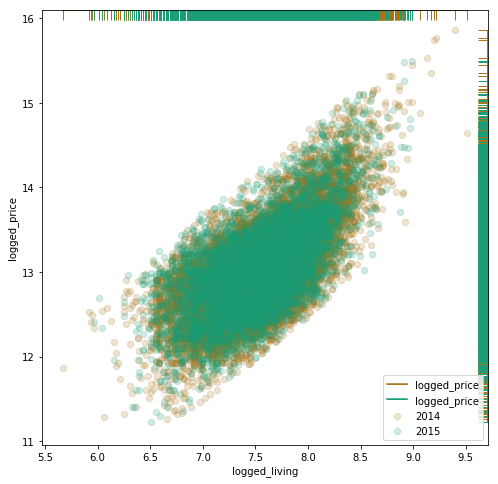

In [20]:
"""Descriptive Figures - 5: Clustering based on year.

"""
cluster = ['2015', '2014']
amap={e[0]:e[1] for e in zip(df['yr'],cluster)}
ax=scatter_by(df, 'logged_living', 'logged_price', by='yr', labeler=amap, mfunc=make_rug, mms=20)
ax.grid(False)
ax.legend(loc='lower right')

pylab.savefig('logged_price ~ logged_living over year', dpi = 80, figsize = (20,6))
plt.show()

In [26]:
""" Model 1:

"""
X = df.as_matrix(columns=["logged_living", "logged_lot", "logged_above"])

y = np.array(df["logged_price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

svr = SVR() 
svr_fit = svr.fit(X_train, y_train) 

svr_pred = svr.predict(X_train)


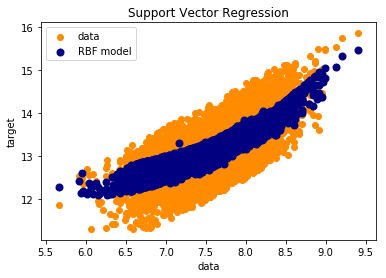

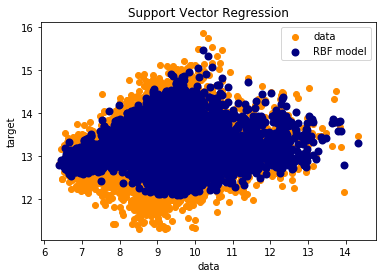

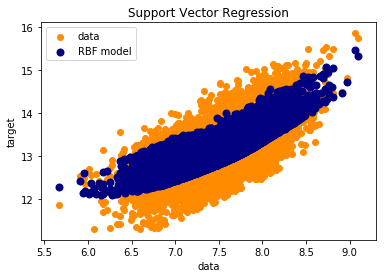

In [27]:
"""Plot the svr over each explanatory variable: 

"""

def plot_regression(X, y, y_pred):
    lw = 2
    plt.scatter(X, y, color='darkorange', label='data')
    plt.scatter(X, y_pred, color='navy', lw=lw, label='RBF model')
    plt.xlabel('data')
    plt.ylabel('target')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    
plot_regression(X_train[:,0], y_train, svr_pred)
plot_regression(X_train[:,1], y_train, svr_pred)
plot_regression(X_train[:,2], y_train, svr_pred)

y_test mean - 13.040830322151404
y_test std - 0.5267844960470608
RMSE - 0.1278417468905579
R2 - 0.5393121832312728


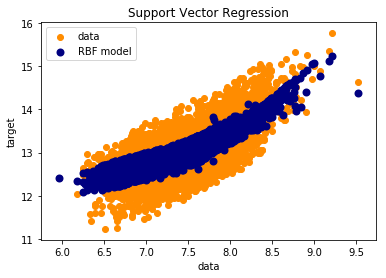

In [28]:
"""Validation: 

"""

svr_pred_test = svr.predict(X_test) #Here we are simply predicting on our input to visualize the results

rmse = metrics.mean_squared_error(y_test, svr_pred_test) #mean-squared-error: (sum((Y_actual-Y_predicted)^2)^0.5
print("y_test mean - {}".format(np.mean(y_test)))
print("y_test std - {}".format(np.std(y_test)))
print("RMSE - {}".format(rmse))
r2 = metrics.r2_score(y_test, svr_pred_test)
print("R2 - {}".format(r2))

plot_regression(X_test[:,0], y_test, svr_pred_test)

In [7]:
"""Function: 

Test the best-fitted "training Vs testing" ratio AND best kernel model.

"""

def model_selection(lst):
    # Set ratio:
    ratios = [8]
    #3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 
    test_sizes = []

    # Set X and Y
    X = df.as_matrix(columns=lst)
    y = np.array(df["logged_price"])
    
    # Set Kernel:
    kernel = ["rbf", "linear"]
    #, "linear"
    for size in ratios:
        test_size = 1/size
        test_sizes.append(test_size)
    
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
        for k in kernel:
            svr = SVR(kernel = k) 
            svr_fit = svr.fit(X_train, y_train) 
            svr_pred = svr.predict(X_train)
            svr_pred_test = svr.predict(X_test) #Here we are simply predicting on our input to visualize the results
            rmse = metrics.mean_squared_error(y_test, svr_pred_test) #mean-squared-error: (sum((Y_actual-Y_predicted)^2)^0.5
            print("Kernel - {}".format(k))
            print("Test data ratio: {} out of 1.".format(np.round(test_size, 2)))
            print("RMSE - {}".format(rmse))
            r2 = metrics.r2_score(y_test, svr_pred_test)
            print("R2 - {}".format(r2))
            print()


In [8]:
"""Function: 

Randomly choose a random number of variables from lst_other, 
and append the variables to the lst_main to make the final list for independent variable. 

"""
# Create a list of independent variables:
lst_main = ["logged_living", "bedrooms", 
           "bathrooms", "yr_built", "month_all"]
lst_other = ["logged_above", "sqft_basement", "logged_lot", "floors"]

# Create random selected variables lists of a given size:
def models(size):
    lst_select = list(itertools.combinations(lst_other,size))
    print(lst_select)
    print()
    print("Model Selected:")
    print()

    lst_models = []
    for ele in lst_select:
        lst_main = ["logged_living", "bedrooms", 
           "bathrooms", "yr_built", "month_all"]
        lst_main.extend(ele)
        lst_models.append(lst_main)
        print(lst_main)

    print()
    return lst_models


In [ ]:
for lst in models(3):
    print(lst)
    model_selection(lst)

[('logged_above', 'sqft_basement', 'logged_lot'), ('logged_above', 'sqft_basement', 'floors'), ('logged_above', 'logged_lot', 'floors'), ('sqft_basement', 'logged_lot', 'floors')]

Model Selected:

['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'sqft_basement', 'logged_lot']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'sqft_basement', 'floors']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'logged_lot', 'floors']
['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'sqft_basement', 'logged_lot', 'floors']

['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_above', 'sqft_basement', 'logged_lot']
Kernel - rbf
Test data ratio: 0.15 out of 1.
RMSE - 0.17786271011872123
R2 - 0.3796481777010742

Kernel - linear
Test data ratio: 0.15 out of 1.
RMSE - 0.31277910066609754
R2 - -0.09091492503244769

Kernel - rbf
Test data ratio: 0.14 out of 1.

In [13]:
lst_1 = ['logged_living', 'bedrooms', 'bathrooms', 'yr_built', 'month_all', 'logged_lot', 'floors']
model_selection(lst_1)

Kernel - rbf
Test data ratio: 0.33 out of 1.
RMSE - 0.13599876706539532
R2 - 0.5233270247150315

Kernel - linear
Test data ratio: 0.33 out of 1.
RMSE - 0.4800703591240483
R2 - -0.6826370662591879

Kernel - rbf
Test data ratio: 0.29 out of 1.
RMSE - 0.1339633878050382
R2 - 0.529333697917421

Kernel - linear
Test data ratio: 0.29 out of 1.
RMSE - 0.3900522478036234
R2 - -0.3704076322696941

Kernel - rbf
Test data ratio: 0.25 out of 1.
RMSE - 0.13103235557832538
R2 - 0.5368190266012074

Kernel - linear
Test data ratio: 0.25 out of 1.
RMSE - 0.37347018751032124
R2 - -0.3201646587438307

Kernel - rbf
Test data ratio: 0.22 out of 1.
RMSE - 0.13076188317874898
R2 - 0.5358639581886455

Kernel - linear
Test data ratio: 0.22 out of 1.
RMSE - 0.42268418414490944
R2 - -0.5003069655788115

Kernel - rbf
Test data ratio: 0.2 out of 1.
RMSE - 0.13073152310550862
R2 - 0.5418994983686176

Kernel - linear
Test data ratio: 0.2 out of 1.
RMSE - 0.4180999887580803
R2 - -0.4650775117763577

Kernel - rbf
Test